In [5]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 8.5 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.6 MB 8.4 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.6 MB 7.3 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.6 MB 6.9 MB/s eta 0:00:01
   -------------------------- ------------- 6.3/9.6 MB 6.4 MB/s eta 0:00:01
   ----------------------------- ---------- 7.1/9.6 MB 6.1 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.6 MB 5.8 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.6 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.6 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 5.1 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
  


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\nstr9\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
# Dataset Link-  https://www.kaggle.com/datasets/skullagos5246/upi-transactions-2024-dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- PART 1: Loading and Preparing the Dataset ---")

try:
    df = pd.read_csv('upi_transactions.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    print("Dataset 'upi_transactions.csv' loaded and prepared successfully.")
    print("\nDataFrame Info:")
    df.info()
    print("\nFirst 5 rows of your data:")
    print(df.head())
except FileNotFoundError:
    print("Error: The file 'upi_transactions.csv' was not found.")
    print("Please make sure the CSV file is in the same directory as your script.")
except Exception as e:
    print(f"An error occurred: {e}")

--- PART 1: Loading and Preparing the Dataset ---
Dataset 'upi_transactions.csv' loaded and prepared successfully.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250000 entries, 2024-10-08 15:17:28 to 2024-01-17 15:23:07
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   transaction id      250000 non-null  object
 1   transaction type    250000 non-null  object
 2   merchant_category   250000 non-null  object
 3   amount (INR)        250000 non-null  int64 
 4   transaction_status  250000 non-null  object
 5   sender_age_group    250000 non-null  object
 6   receiver_age_group  250000 non-null  object
 7   sender_state        250000 non-null  object
 8   sender_bank         250000 non-null  object
 9   receiver_bank       250000 non-null  object
 10  device_type         250000 non-null  object
 11  network_type        250000 non-null  object
 12  fraud_flag          250000 non-n


--- PART 2: Performing Core Time Series Analysis and Forecasting ---
Displaying plot: Total Daily UPI Transaction Amount


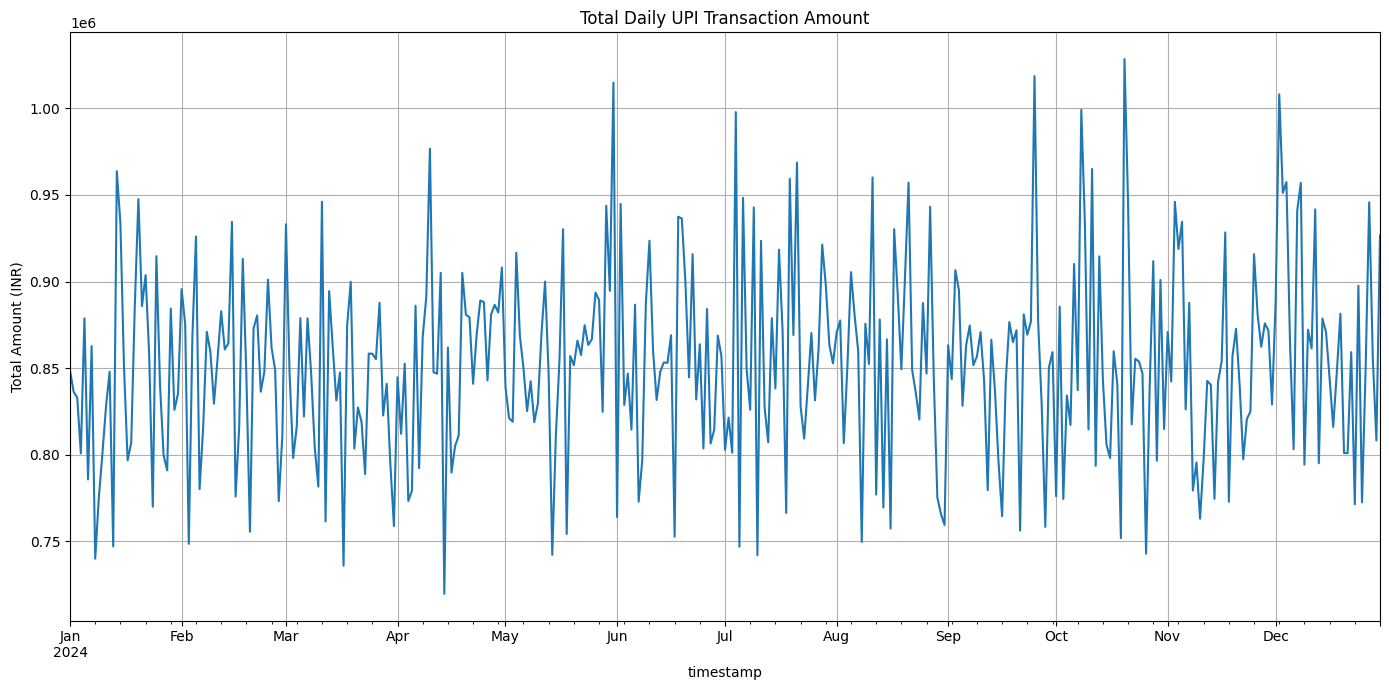

Displaying plot: Decomposition of the Time Series


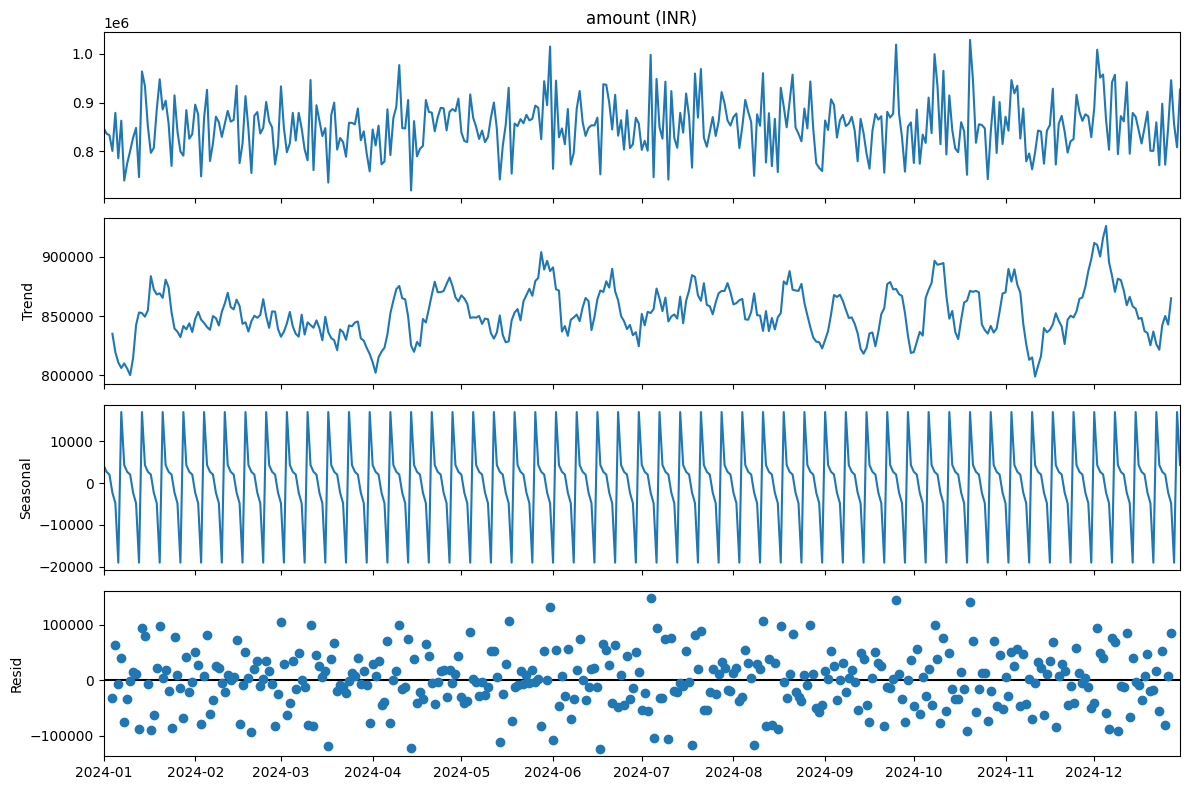

Displaying plot: UPI Daily Amount Forecast


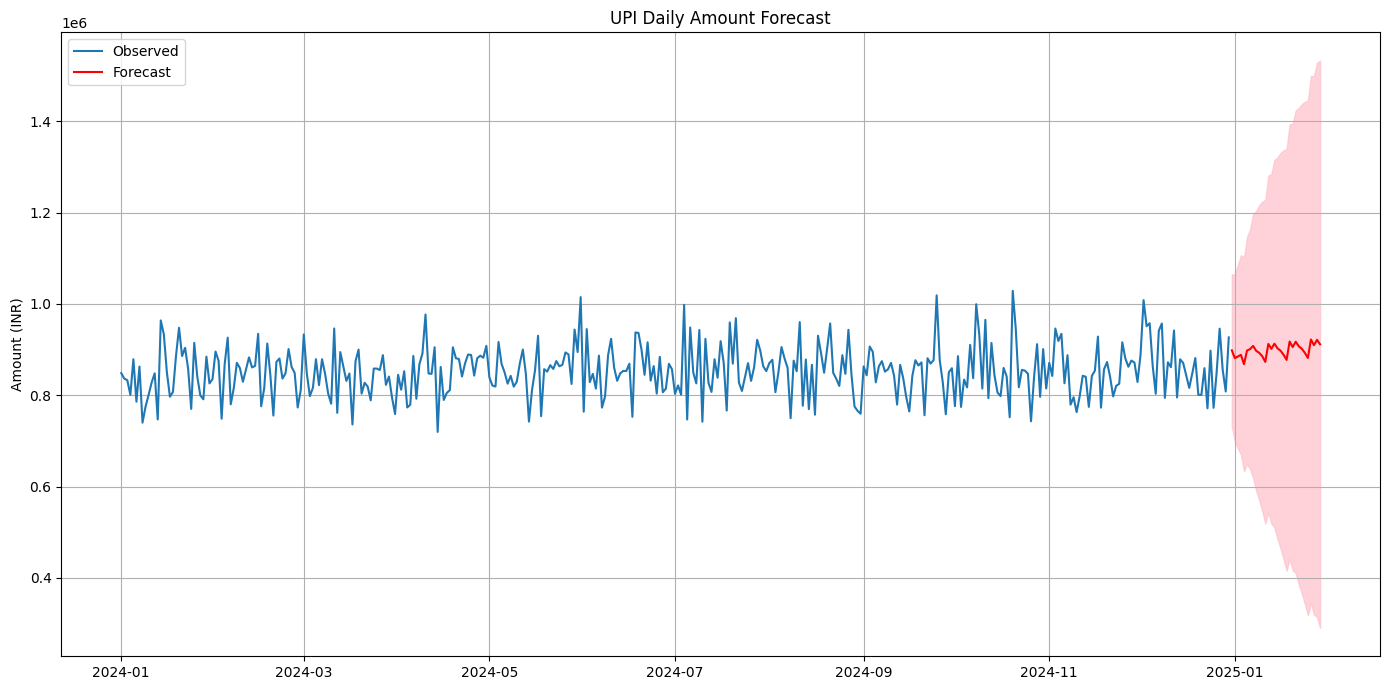

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n--- PART 2: Performing Core Time Series Analysis and Forecasting ---")

successful_df = df[df['transaction_status'] == 'SUCCESS'].copy()
daily_series = successful_df['amount (INR)'].resample('D').sum()

print("Displaying plot: Total Daily UPI Transaction Amount")
daily_series.plot(figsize=(14, 7), title='Total Daily UPI Transaction Amount', grid=True)
plt.ylabel('Total Amount (INR)')
plt.tight_layout()
plt.show()

print("Displaying plot: Decomposition of the Time Series")
decomposition = seasonal_decompose(daily_series.dropna(), model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

model = SARIMAX(daily_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results = model.fit(disp=False)

forecast_object = results.get_forecast(steps=30)
forecast_mean = forecast_object.predicted_mean
forecast_ci = forecast_object.conf_int()

print("Displaying plot: UPI Daily Amount Forecast")
plt.figure(figsize=(14, 7))
plt.plot(daily_series, label='Observed')
plt.plot(forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.7)
plt.title('UPI Daily Amount Forecast')
plt.ylabel('Amount (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- PART 3: Performing Segmented Analysis by Merchant Category ---
Displaying plot: Daily Transaction Amount by Top 5 Merchant Categories


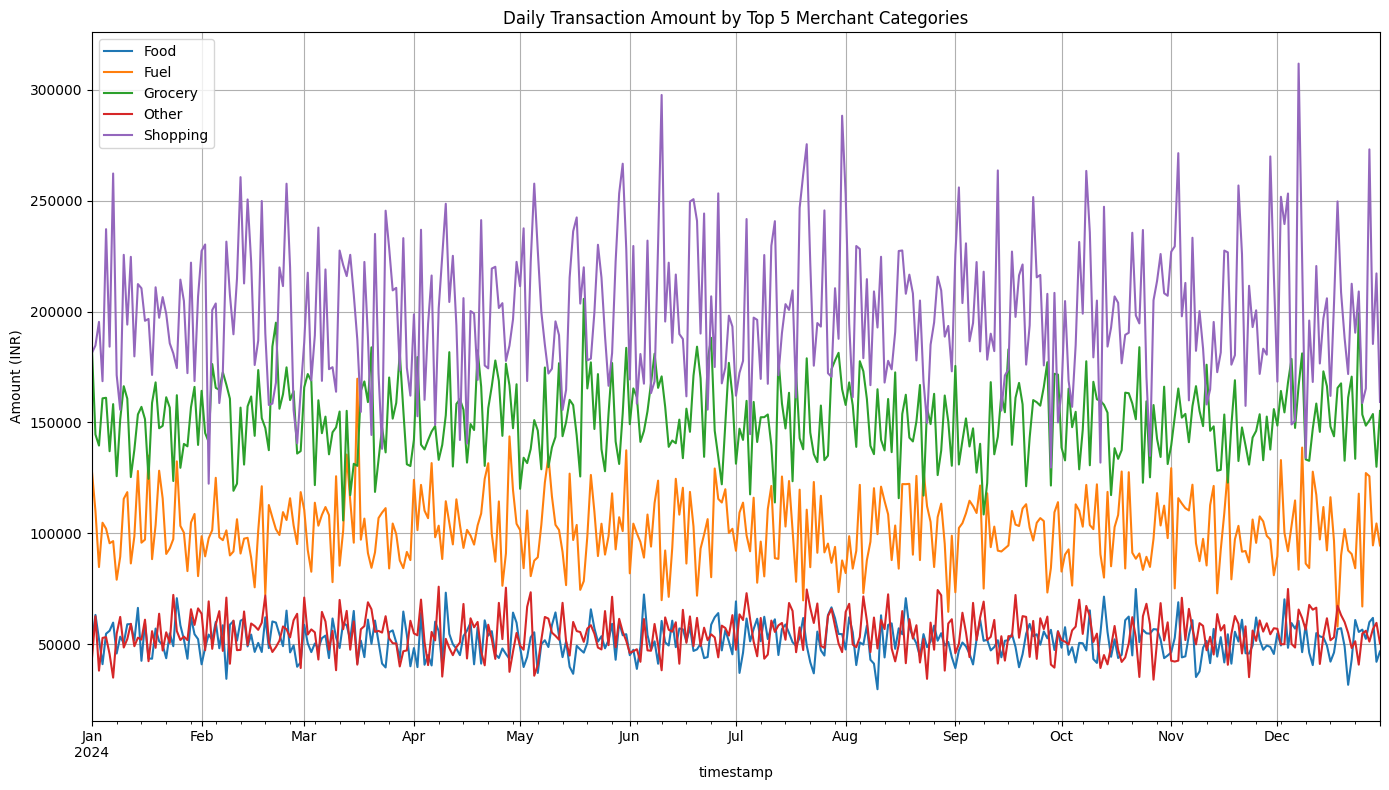


--- Performing Anomaly Detection ---
No significant anomalies detected in the dataset.


In [9]:
# This script assumes 'successful_df' and 'decomposition' from Part 2 are available.

# --- PART 3: SEGMENTED ANALYSIS & ANOMALY DETECTION ---
print("\n--- PART 3: Performing Segmented Analysis by Merchant Category ---")

# Find the top 5 busiest merchant categories
top_categories = successful_df['merchant_category'].value_counts().nlargest(5).index

# Filter the DataFrame to only include these top categories
segmented_series = successful_df[successful_df['merchant_category'].isin(top_categories)].groupby('merchant_category')['amount (INR)'].resample('D').sum().unstack(level=0)

# Plot the trends for the top categories
print("Displaying plot: Daily Transaction Amount by Top 5 Merchant Categories")
plt.figure(figsize=(14, 8))
segmented_series.plot(ax=plt.gca(), grid=True)
plt.title('Daily Transaction Amount by Top 5 Merchant Categories')
plt.ylabel('Amount (INR)')
plt.legend()
plt.tight_layout()
plt.show()


print("\n--- Performing Anomaly Detection ---")
# Use the residuals (the "noise") from the decomposition in Part 2
residuals = decomposition.resid.dropna()

# Identify anomalies (any data point beyond 3 standard deviations from the average)
threshold = residuals.std() * 3
anomalies = residuals[abs(residuals) > threshold]

if not anomalies.empty:
    print(f"Found {len(anomalies)} potential anomalies. Anomalies found on:")
    print(anomalies.index.date)
    
    # Perform Root Cause Analysis for the first detected anomaly
    anomaly_date = anomalies.index[0].date()
    print(f"\n--- Root Cause Analysis for Anomaly on {anomaly_date} ---")
    
    df_anomaly_day = successful_df[successful_df.index.date == anomaly_date]
    
    print("\nTop Merchant Categories on this day:")
    print(df_anomaly_day['merchant_category'].value_counts(normalize=True).head())
    
    print("\nTop Sender Banks on this day:")
    print(df_anomaly_day['sender_bank'].value_counts(normalize=True).head())
else:
    print("No significant anomalies detected in the dataset.")


--- Performing Fraud Detection Analysis ---
Displaying plot: Daily Fraudulent Transactions


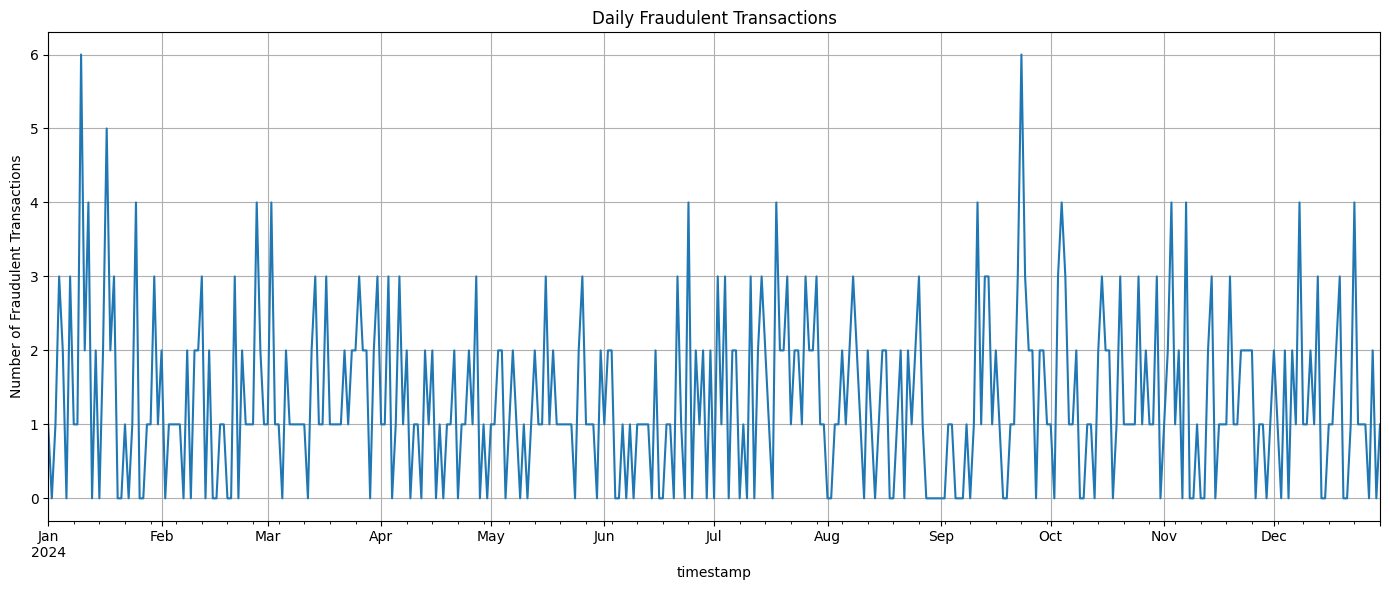


Total Transactions: 250000
Fraudulent Transactions: 480 (0.19%)
Displaying plot: Distribution of Transactions by Hour of Day


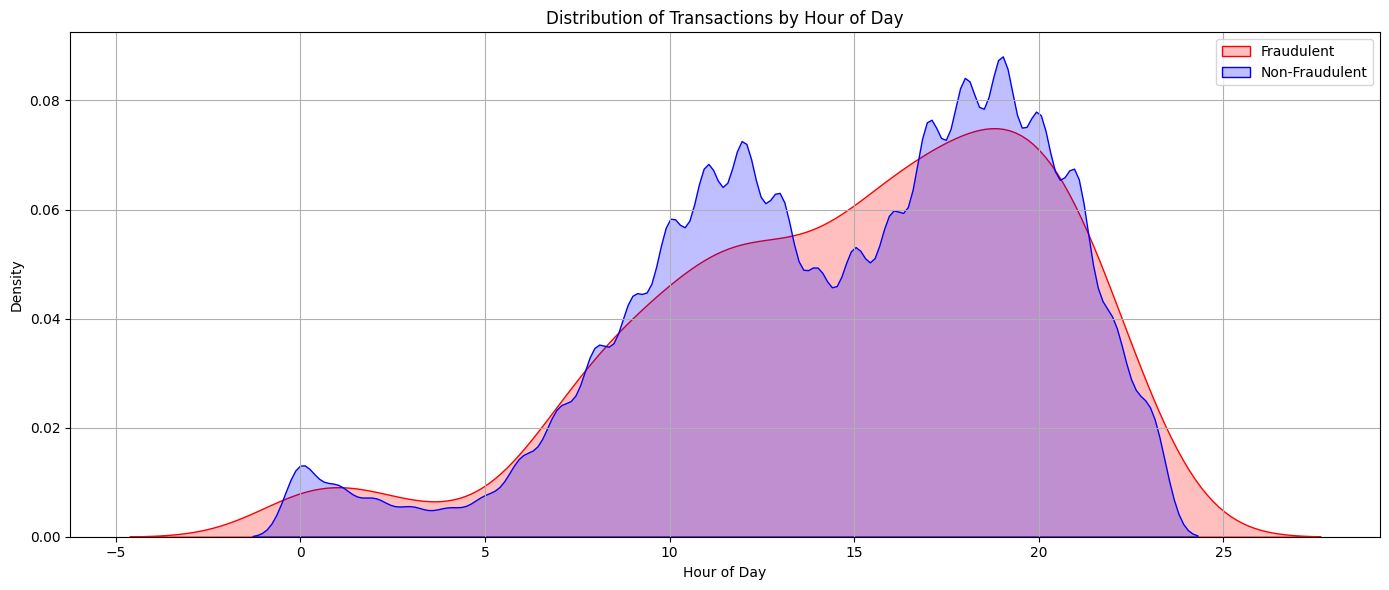

Displaying plot: Fraud Rate (%) by Merchant Category


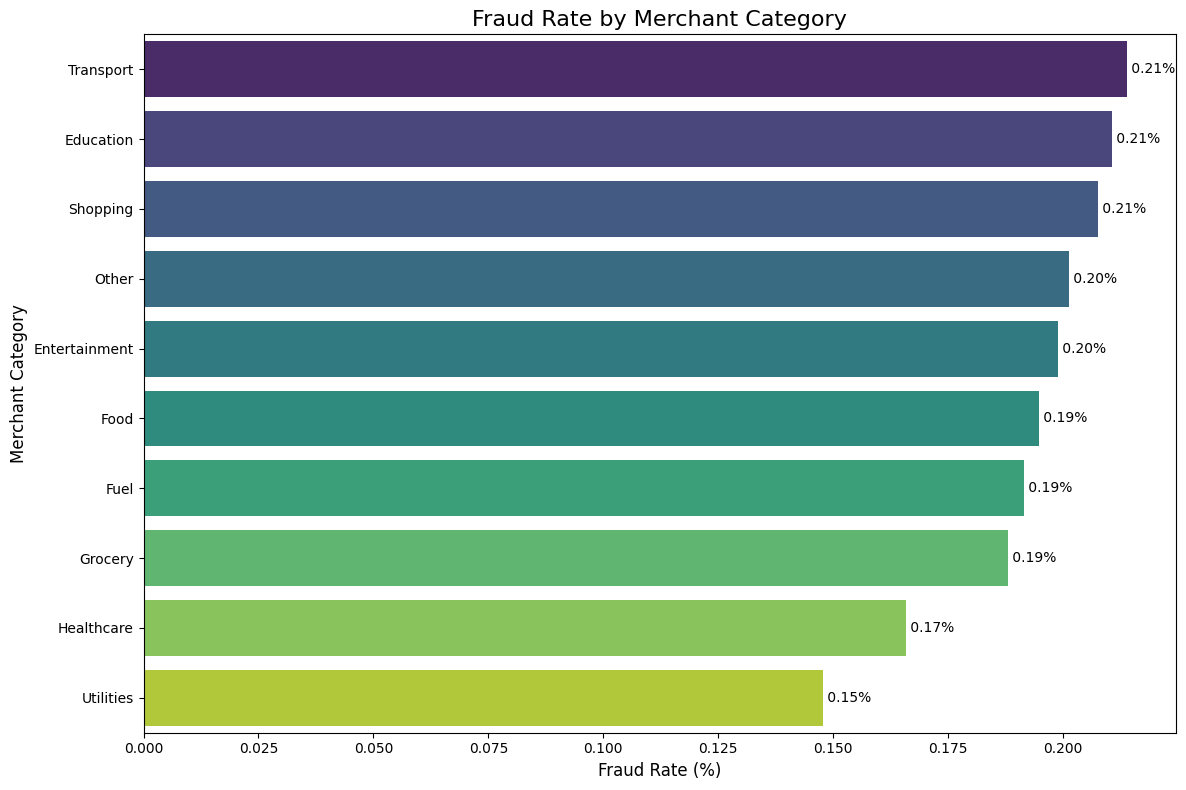

In [10]:
# --- PART 4: FRAUD DETECTION ANALYSIS ---
print("\n--- Performing Fraud Detection Analysis ---")

# 1. Create and plot a time series of daily fraudulent transactions
daily_fraud = df['fraud_flag'].resample('D').sum()
print("Displaying plot: Daily Fraudulent Transactions")
plt.figure(figsize=(14, 6))
daily_fraud.plot(title='Daily Fraudulent Transactions', grid=True)
plt.ylabel('Number of Fraudulent Transactions')
plt.tight_layout()
plt.show()

# 2. Profile fraudulent vs. non-fraudulent transactions
fraudulent_count = df['fraud_flag'].sum()
print(f"\nTotal Transactions: {len(df)}")
print(f"Fraudulent Transactions: {fraudulent_count} ({fraudulent_count/len(df):.2%})")

# 3. Compare fraud distribution by hour of day
print("Displaying plot: Distribution of Transactions by Hour of Day")
plt.figure(figsize=(14, 6))
sns.kdeplot(df[df['fraud_flag'] == 1]['hour_of_day'], label='Fraudulent', color='red', fill=True, warn_singular=False)
sns.kdeplot(df[df['fraud_flag'] == 0]['hour_of_day'], label='Non-Fraudulent', color='blue', fill=True)
plt.title('Distribution of Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Visualize Fraud Rate by Merchant Category
print("Displaying plot: Fraud Rate (%) by Merchant Category")

# Calculate the fraud rate for each category
# The .get(1, 0) handles categories with no fraudulent transactions, preventing errors
fraud_rate_series = df.groupby('merchant_category')['fraud_flag'].value_counts(normalize=True).unstack().get(1, pd.Series(0, index=df['merchant_category'].unique())).fillna(0)
fraud_rate = (fraud_rate_series * 100).sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
# Use the new recommended syntax for Seaborn
sns.barplot(x=fraud_rate.values, y=fraud_rate.index, hue=fraud_rate.index, palette='viridis', legend=False)

plt.title('Fraud Rate by Merchant Category', fontsize=16)
plt.xlabel('Fraud Rate (%)', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)

# Add percentage labels to the bars for clarity
for index, value in enumerate(fraud_rate):
    plt.text(value, index, f' {value:.2f}%', va='center')

plt.tight_layout()
plt.show()